<a href="https://colab.research.google.com/github/V-Nayak/Projects/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To detect hate speech in tweets via classifying racist or sexist tweets from other tweets.

# **Lets Import Libraries**

In [ ]:
# loading the libraries

import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from nltk.stem.porter import *
,


pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train=pd.read_csv("/content/drive/MyDrive/ML Projects/TSA/train_E6oV3lV.csv")
test=pd.read_csv("/content/drive/MyDrive/ML Projects/TSA/test_tweets_anuFYb8.csv")

In [ ]:
train.describe

<bound method NDFrame.describe of           id  label  \
0          1      0   
1          2      0   
2          3      0   
3          4      0   
4          5      0   
...      ...    ...   
31957  31958      0   
31958  31959      0   
31959  31960      0   
31960  31961      1   
31961  31962      0   

                                                                                                                                     tweet  
0                                    @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1               @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                                      bihday your majesty  
3                                                   #model   i love u take with u all the time in urð±!!! ðððð
ð

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
train.shape, test.shape

((31962, 3), (17197, 2))

train data has labeled 1 for sexist and racist tweets from other tweets(0)

# **Data inspection**

In [ ]:
# lets check for Non racist or Non sexist tweets.
train[train['label']== 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [ ]:
# lets check for racist or sexist tweets

train[train['label']== 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


In [ ]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

NOw here we gone check the distributio of lenght of the tweets(in terms of words)

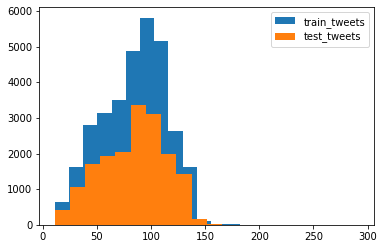

In [ ]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [ ]:
# Combining the data

combi = train.append(test, ignore_index =True)
combi.shape

(49159, 3)

# **Data cleaning**

In [ ]:
# to remove unwanted text patterns

def remove_pattern(input_txt, pattern):
    r=re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '',input_txt)
    return input_txt

# here we will create new column by removing the user name/handler of Tweeter

combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [ ]:
# Removing the punctuations, Numbers and special characters

combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
combi.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [ ]:
# Removing Short words(<=3)
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [ ]:
# text Normalisation(ntlks PorterStemmer() function) after tokenisation(splitting a string text into tokens) the tweets

# tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()


0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# nomrlize the tokenzised tweets


stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])

In [ ]:
# stiching together the tokenized word(using nltk MosesDetokenizer function)

for i in range(len(tokenized_tweet)): 
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet
combi.shape

(49159, 4)

# **Story Genaration and Visualization from tweets**

In [ ]:
!pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install textbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 4.9 MB 42.7 MB/s 
     |████████████████████████████████| 28.2 MB 1.4 MB/s 
     |████████████████████████████████| 120 kB 71.3 MB/s 
     |████████████████████████████████| 6.6 MB 48.8 MB/s 


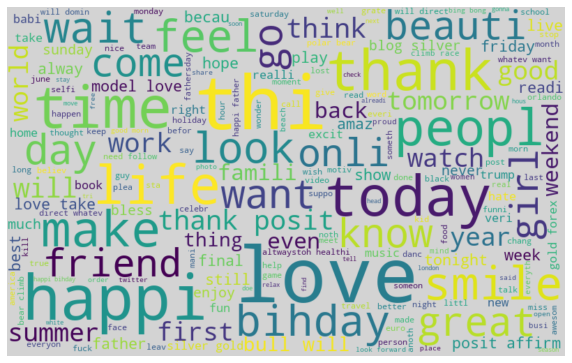

In [ ]:
# visualise all the words using world cloud plot

all_words =' '.join([text for text in combi['tidy_tweet']]) 
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(width=800,height=500,background_color ='lightGray', random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

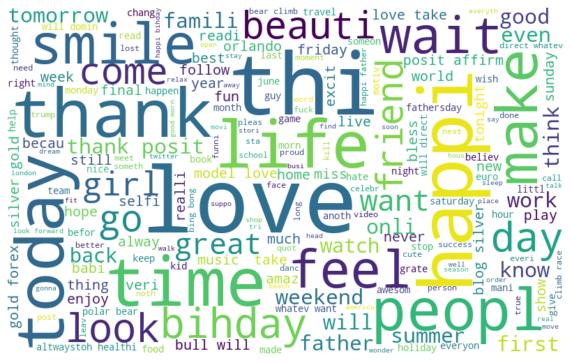

In [ ]:
# visualise the words in Non Racist or Sexist 

Normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 500,background_color ='white',stopwords = stopwords,max_font_size=130,min_font_size = 5).generate(Normal_words) 
#wordcloud = WordCloud(width=500,height=800, random_state=21, max_font_size=110).generate(Normal_words)
plt.figure(figsize=(10,7),facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


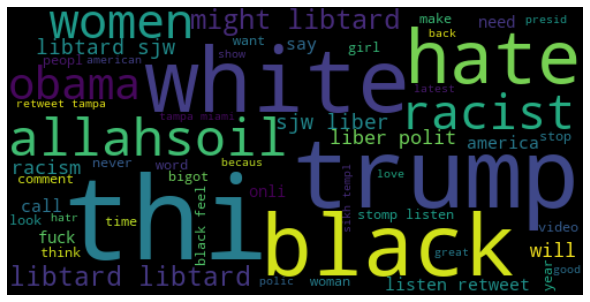

In [ ]:
# visualise the words in Racist or Sexist 

Negative_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 

from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(width=500,height=250, random_state=21,max_font_size=100, min_font_size = 10).generate(Negative_words)
plt.figure(figsize=(8,8),facecolor = None, edgecolor = None )
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


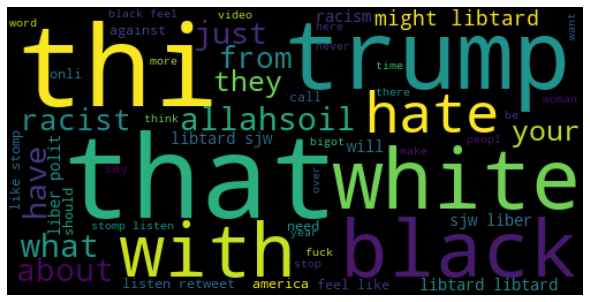

In [ ]:
 # visualise the words in Racist or Sexist 

Negative_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 

from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(width=500,height=250, stopwords=["obama", "women","girl"],random_state=21,max_font_size=100, min_font_size = 10).generate(Negative_words)
plt.figure(figsize=(8,8),facecolor = None, edgecolor = None )
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
 


## **Understanding the impact of Hashtags on tweets sentiment**

In [ ]:
# function to collect hashtags 
def hashtag_extract(x):
  hashtags = []    
# Loop over the words in the tweet    
  for i in x:
    ht = re.findall(r"#(\w+)", i)        
    hashtags.append(ht)
  return hashtags
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tweet'][combi['label'] == 0]) 
# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(combi['tweet'][combi['label'] == 1]) 
# unnesting list 
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

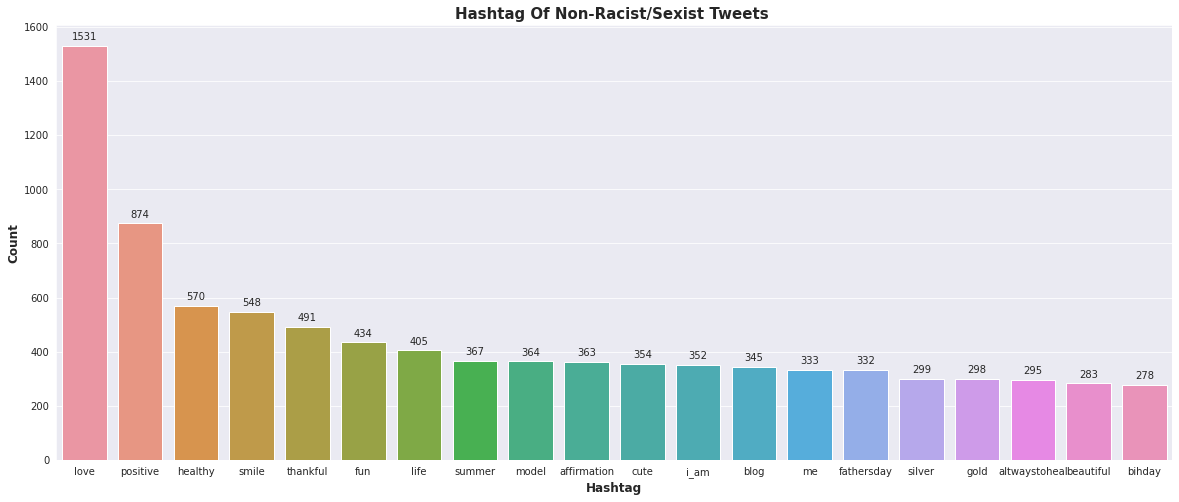

In [ ]:
a = nltk.FreqDist(HT_regular) 
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x='Hashtag', y='Count', data = d,alpha=1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Hashtag Of Non-Racist/Sexist Tweets ',weight='bold', size=15)
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Hashtag', size=12, weight='bold')
plt.show()




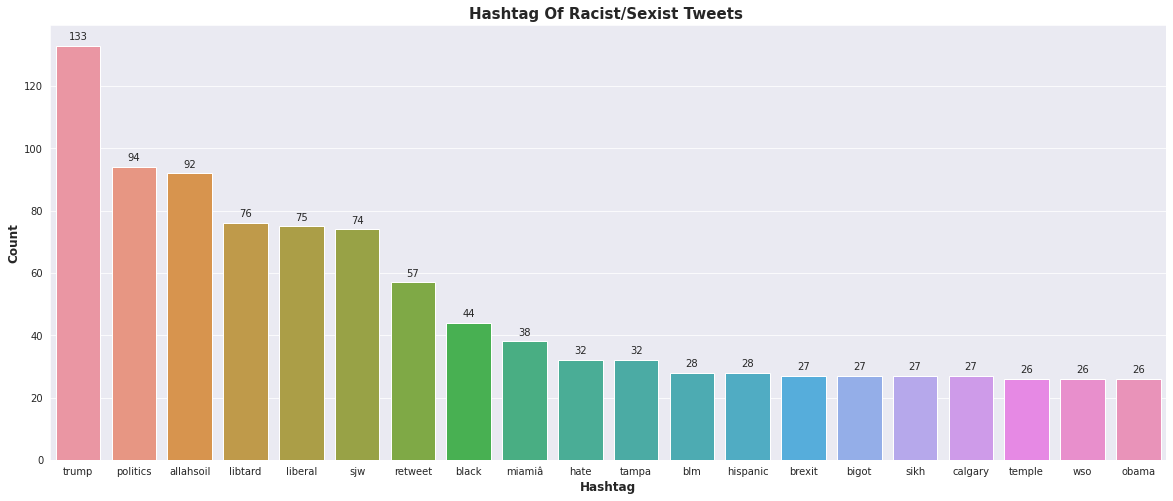

In [ ]:
b = nltk.FreqDist(HT_negative) 
e = pd.DataFrame({'Hashtag': list(b.keys()),
                  'Count': list(b.values())}) 

# selecting top 20 most frequent hashtags     
e = e.nlargest(columns="Count", n = 20) 
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x='Hashtag', y='Count', data = e,alpha=1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Hashtag Of Racist/Sexist Tweets ',weight='bold', size=15)
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Hashtag', size=12, weight='bold')
plt.show()


## **Bag of Words**

In [ ]:
#feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # import gensim
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2,max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

## **TF-IDF Features**

In [ ]:
 
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

# **Model Building**

## **Logrig on BOW**

In [ ]:
# Extracting train and test BOW features

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

#splitting the data into training and validation set
xtrain_bow,xvalid_bow,ytrain,yvalid = train_test_split(train_bow,train['label'],random_state=42,test_size=0.2)

lreg = LogisticRegression()

#training the model 
lreg.fit(xtrain_bow,ytrain)
prediction = lreg.predict_proba(xvalid_bow)

#predicting on the validation set
prediction_int = prediction[:,1] >=0.2 # if prediction is greater than or equal to 0.2 then 1 else 0
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid,prediction_int) #calculating f1 score for the validation set

0.5663531870428422

In [ ]:
print('Accuracy Score', accuracy_score(yvalid,prediction_int))
print("\nconfusion_matrix", confusion_matrix(yvalid,prediction_int))

Accuracy Score 0.9350852494916315

confusion_matrix [[5707  230]
 [ 185  271]]


## **Logrig on Tf-Idf**

In [ ]:
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain) 

prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 

# calculating f1 score for the validation set
print("f1_score")
f1_score(yvalid, prediction_int) 

f1_score


0.5714285714285715

## **Decision Tree**

In [ ]:
df=pd.DataFrame(combi,columns=['id','label','tweet','tidy_tweet'])
df.to_csv('combi.csv', index=False)
df.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


In [ ]:
 #Function importing Dataset
def importdata():
     
    balance_data = pd.read_csv('combi.csv',sep= ',', header = None)
      
    # Printing the dataswet shape
    print ("Dataset Length: ", len(balance_data))
    print ("Dataset Shape: ", balance_data.shape)
      
    # Printing the dataset obseravtions
    print ("Dataset: ",balance_data.head())
    return balance_data

# Function to split the dataset
def splitdataset(balance_data):
  
    # Separating the target variable
    X = balance_data.values[:, 1:4]
    Y = balance_data.values[:, 0]
  
    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split( 
    X, Y, test_size = 0.2, random_state = 100)
      
    return X, Y, X_train, X_test, y_train, y_test

    # Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
  
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)
  
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini

# Function to perform training with entropy.
def tarin_using_entropy(X_train, X_test, y_train):
  
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 3, min_samples_leaf = 5)
  
    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy

    # Function to make predictions
def prediction(X_test, clf_object):
  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred
      
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy : ",
    accuracy_score(y_test,y_pred)*100)
      
    print("Report : ",
    classification_report(y_test, y_pred))
  
# Driver code
def main():
      
    # Building Phase
    data = importdata()
    X, Y, X_train, X_test, y_train, y_test = splitdataset(data)
    clf_gini = train_using_gini(X_train, X_test, y_train)
    clf_entropy = tarin_using_entropy(X_train, X_test, y_train)
      
    # Operational Phase
    print("Results Using Gini Index:")
      
    # Prediction using gini
    y_pred_gini = prediction(X_test, clf_gini)
    cal_accuracy(y_test, y_pred_gini)
      
    print("Results Using Entropy:")
    # Prediction using entropy
    y_pred_entropy = prediction(X_test, clf_entropy)
    cal_accuracy(y_test, y_pred_entropy)
      
      
# Calling main function
if __name__=="__main__":
    main()

Dataset Length:  49160
Dataset Shape:  (49160, 4)
Dataset:      0      1  \
0  id  label   
1   1    0.0   
2   2    0.0   
3   3    0.0   
4   4    0.0   

                                                                                                                            2  \
0                                                                                                                       tweet   
1                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run   
2  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked   
3                                                                                                         bihday your majesty   
4                                      #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦     

                                                                    

ValueError: ignored